In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [12]:
train_dir = r'D:\Brain\brain-256'
test_dir = r'D:\Brain\brain-256-testing'

classes = ["glioma", "meningioma", "pituitary", "notumor"]

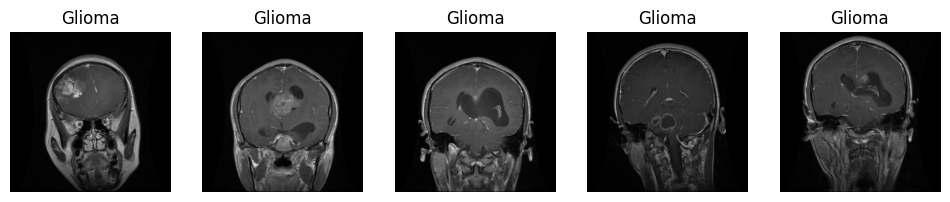

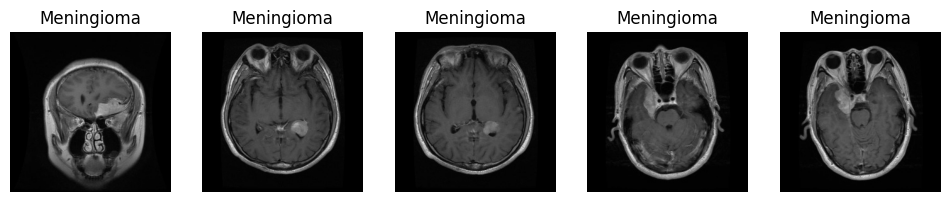

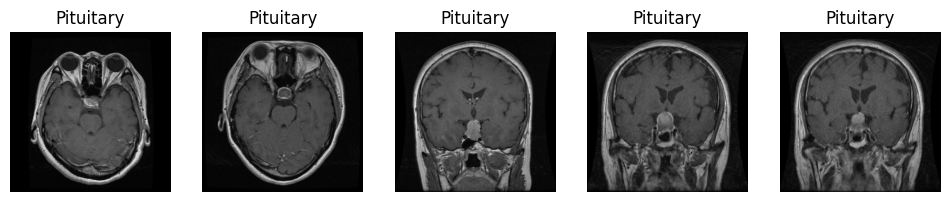

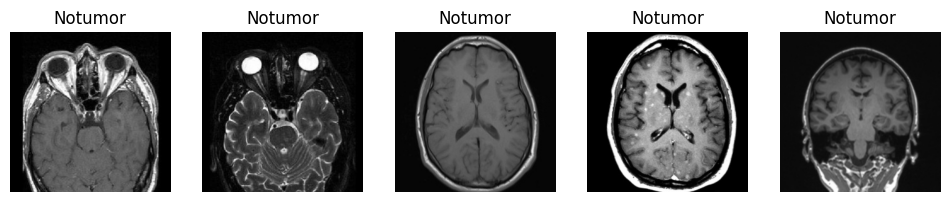

In [13]:
# -----------------------------
# Function to display sample images
# -----------------------------
def display_sample_images(image_dir, title, num_samples=5):
    plt.figure(figsize=(12, 4))
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)[:num_samples]]
    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display sample images for each class
for cls in classes:
    display_sample_images(os.path.join(train_dir, cls), cls.replace('_', ' ').title())

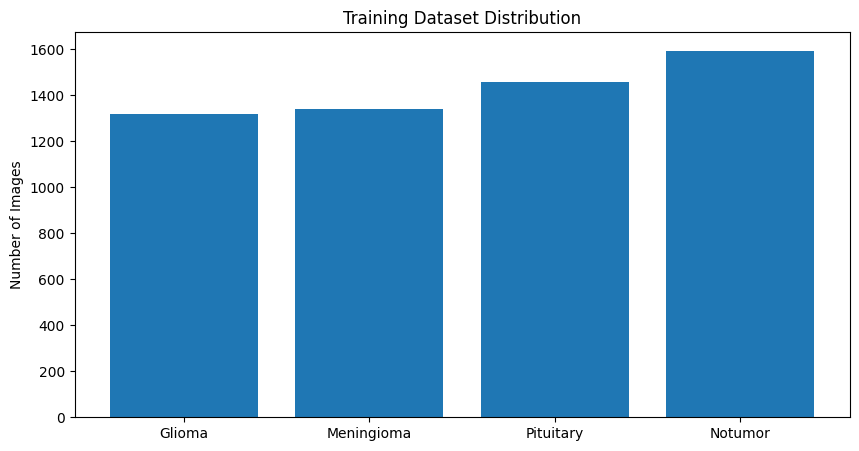

In [14]:

# -----------------------------
# Count images per class
# -----------------------------
def get_image_count(image_dir):
    return len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

counts = [get_image_count(os.path.join(train_dir, cls)) for cls in classes]
plt.figure(figsize=(10, 5))
plt.bar([cls.replace('_', ' ').title() for cls in classes], counts)
plt.ylabel('Number of Images')
plt.title('Training Dataset Distribution')
plt.show()

In [15]:
# -----------------------------
# Data Generators
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # resize to 256x256
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # keep order for evaluation
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [16]:
# -----------------------------
# Build Model (ResNet101)
# -----------------------------
model = models.Sequential()
model.add(ResNet101(include_top=False, weights='imagenet', pooling='avg'))
model.add(layers.Dense(4, activation='softmax'))

# Freeze ResNet layers
for layer in model.layers[0].layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




171446536/171446536 [==============================] - 70s 0us/step


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/15


178/178 [==============================] - 690s 4s/step - loss: 1.0557 - accuracy: 0.5530 - val_loss: 0.7456 - val_accuracy: 0.7250
Epoch 2/15
178/178 [==============================] - 679s 4s/step - loss: 0.6515 - accuracy: 0.7717 - val_loss: 0.5907 - val_accuracy: 0.7867
Epoch 3/15
178/178 [==============================] - 713s 4s/step - loss: 0.5279 - accuracy: 0.8144 - val_loss: 0.5371 - val_accuracy: 0.7961
Epoch 4/15
178/178 [==============================] - 697s 4s/step - loss: 0.4679 - accuracy: 0.8419 - val_loss: 0.4940 - val_accuracy: 0.8180
Epoch 5/15
178/178 [==============================] - 698s 4s/step - loss: 0.4307 - accuracy: 0.8514 - val_loss: 0.4669 - val_accuracy: 0.8203
Epoch 6/15
178/178 [==============================] - 720s 4s/step - loss: 0.4071 - accuracy: 0.8563 - val_loss: 0.4509 - val_accuracy: 0.8289
Epoch 7/15
178/178 [==============================] - 712s 4s/step - loss: 0.3875 - accuracy: 0.8653 - val_loss: 0.4300 - val_accuracy: 0.83

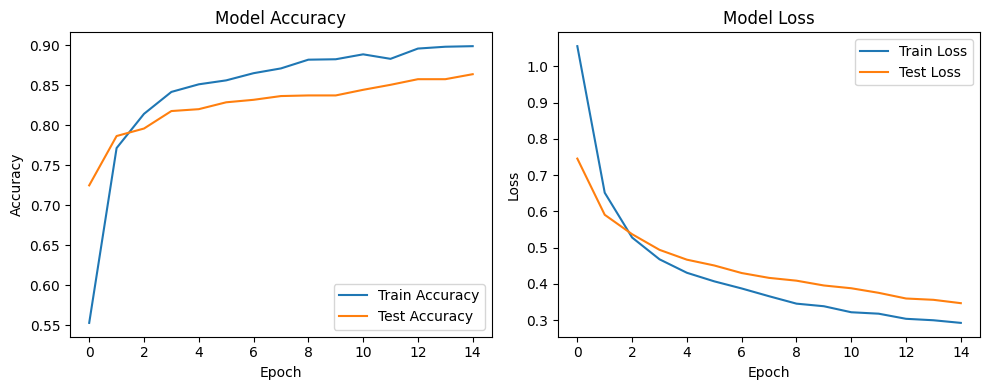

In [18]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
model.save('brain_tumor_resnet101.h5')

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import os

# -----------------------------
# Load the trained model
# -----------------------------
MODEL_PATH = "brain_tumor_resnet101.h5"
model = load_model(MODEL_PATH)

# Class labels
classes = ["Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor", "No Tumor"]

# -----------------------------
# Function to predict tumor type
# -----------------------------
def predict_tumor(img_path):
    # Load image
    img = Image.open(img_path).convert('RGB')
    img = img.resize((256, 256))  # resize to match training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    return predicted_class, confidence

# -----------------------------
# Example usage
# -----------------------------
img_path = r"D:\Brain\brain-256-testing\glioma\Te-gl_0010.jpg"  # replace with your image path
predicted_class, confidence = predict_tumor(img_path)

print(f"Predicted Tumor Type: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


1/1 [==============================] - 2s 2s/step
Predicted Tumor Type: Glioma Tumor
Confidence: 76.09%
